In [1]:
from SpatialUMAP import *
from PlottingTools import *

#### Plot lineages density in UMAP space with PD-L1 and PD1 overlays

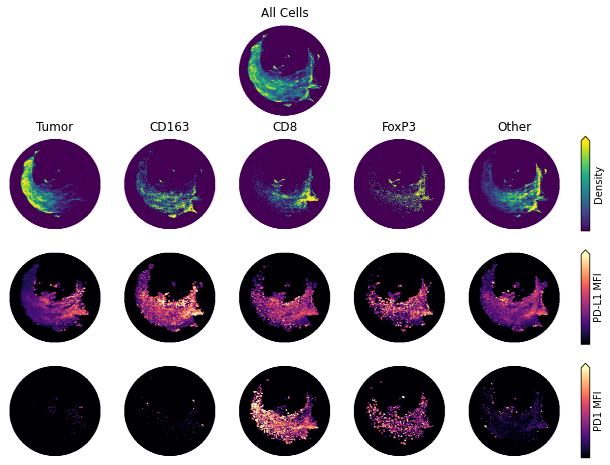

In [3]:
# load spatial_umap object
spatial_umap = pickle.load(open('data/pickles/spatial_umap.pkl', 'rb'))

# set meshgrid / bins for 2d plots based on UMAP x, y distributions
n_bins = 200
xx = np.linspace(np.min(spatial_umap.umap_test[:, 0]), np.max(spatial_umap.umap_test[:, 0]), n_bins + 1)
yy = np.linspace(np.min(spatial_umap.umap_test[:, 1]), np.max(spatial_umap.umap_test[:, 1]), n_bins + 1)
n_pad = 30

# get figure and axes
f, ax = plt.subplots(4, 6, figsize=(12, 8), facecolor='white')

# color maps
cmap_viridis = plt.get_cmap('viridis')
cmap_viridis.set_under('white')
cmap_magma = plt.get_cmap('magma')
cmap_magma.set_under('white')
cmap_bwr = plt.get_cmap('bwr')

# plot cmaps
plt_cmap(ax=ax[1, 5], cmap=cmap_viridis, extend='max', width=0.01, ylabel='Density')
plt_cmap(ax=ax[2, 5], cmap=cmap_magma, extend='max', width=0.01, ylabel='PD-L1 MFI')
plt_cmap(ax=ax[3, 5], cmap=cmap_magma, extend='max', width=0.01, ylabel='PD1 MFI')

# clear unneeded axes
[ax[_].set(visible=False) for _ in [(0, 0), (0, 1), (0, 3), (0, 4), (0, 5)]]

# plot 2d denisty in umap of all cells
plot_2d_density(spatial_umap.umap_test[:, 0], spatial_umap.umap_test[:, 1], bins=[xx, yy], n_pad=n_pad, ax=ax[0, 2], cmap=cmap_viridis)
ax[0, 2].set(title='All Cells')

# set lineages to show and in what order
lineages_plot = ['Tumor', 'CD163', 'CD8', 'FoxP3', 'Other']

# get MFI log scaled for PD-L1
w = {'PD-L1': spatial_umap.cells['PDL1_520'].values[spatial_umap.cells['umap_test']]}
w['PD-L1'] = np.log(0.1 * w['PD-L1'] + 0.1)
w['PD-L1'] -= np.min(w['PD-L1'])

# get MFI log scaled for PD1
w['PD1'] = spatial_umap.cells['PD1_650'].values[spatial_umap.cells['umap_test']]
w['PD1'] = np.log(0.1 * w['PD1'] + 0.01)
w['PD1'] -= np.min(w['PD1'])
w['PD1'] = np.maximum(w['PD1'] - 4, 0)

for i in range(len(lineages_plot)):
    # cells of lineage(s)
    idx = spatial_umap.cells['Lineage'].values[spatial_umap.cells['umap_test']] == lineages_plot[i]
    ax[1, i].cla()
    ax[1, i].set(title=lineages_plot[i])

    # plot density
    plot_2d_density(spatial_umap.umap_test[idx, 0], spatial_umap.umap_test[idx, 1], bins=[xx, yy], ax=ax[1, i], cmap=cmap_viridis, vlim=.95)

    # plot PD-L1 MFI
    plot_2d_density(spatial_umap.umap_test[idx, 0], spatial_umap.umap_test[idx, 1], bins=[xx, yy], w=w['PD-L1'][idx], ax=ax[2, i],
                    cmap=cmap_magma, vlim=np.array([0, np.quantile(w['PD-L1'], .975)]))
    # plot PD1 MFI
    plot_2d_density(spatial_umap.umap_test[idx, 0], spatial_umap.umap_test[idx, 1], bins=[xx, yy], w=w['PD1'][idx], ax=ax[3, i], cmap=cmap_magma,
                    vlim=np.array([0, np.quantile(w['PD1'], .975)]))


